# 1. Backpropagation

Okay, let's get started. I'm doing this because a year into my career as a machine learning engineer, I was asked to code backpropagation for a simple neural network from scratch and failed miserably. So I thought it might be good to dive back into the roots and really understand what's going on, before I go back to using transformers and convolutions and SwiGLUs and whatever else is going on in the industry these days. If you're like me and got into all this without any solid educational foundation in deep learning from a prestigious institution, then feel free to follow along. But enough about me. We're here to do some math and coding. Hopefully not too much math.

## 1.1 Math

Ah dang. Well, whatever. The intuition of backpropagation is quite simple. We have a function $f(x) = y$ and we'd like to minimize the loss function $L(y)$. Consider a simple example where $f(x)$ is a neural network with 2 linear layers, with the sigmoid activation after each one:

$f(x) = S(L_2(S(L_1(x)))) = S((S(XW_1 + b_1))W_2 + b_2))$

To update the parameters $W_1, W_2, b_1$, and $b_2$, we need to calculate the loss gradient with respect to each of them, which is the current rate of change of the loss with respect to each specific parameter. Moving each parameter in the opposite direction of these gradients will cause the loss to decrease.

We can obtain these gradients by taking the original loss gradient with respect to the output and backpropagating it through the layers, multiplying by each component as per the chain rule to get the value we need. For example, if we want the loss gradient with respect to $b_2$, we must obtain:

$\frac{dL}{db_2} = \frac{dL}{dS(L_2(S(L_1(x))))} * \frac{dS(L_2(S(L_1(x))))}{dL_2(S(L_1(x)))} * \frac{dL_2(S(L_1(x)))}{db_2}$

Essentially, we need to use the chain rule to unravel the neural network function until we have $L_2(S(L_1(x))) = (S(XW_1 + b_1))W_2 + b_2$, the part of the function that directly involves $b_2$.

Similarly, if we want it with respect to $b_1$, the formula is:

$\frac{dL}{db_1} = \frac{dL}{dS(L_2(S(L_1(x))))} * \frac{dS(L_2(S(L_1(x))))}{dL_2(S(L_1(x)))} * \frac{dL_2(S(L_1(x)))}{dS(L_1(x))} * \frac{dS(L_1(x))}{dL_1(x)} * \frac{dL_1(x)}{db_1}$

As you can see, the two gradients share some computation. Moreover, the expression $\frac{dL_2(S(L_1(x)))}{dS(L_1(x))}$ in the equation above can only be calculated using the inputs and outputs of layer 2: thus for layer 1 to be able to obtain the gradients for $W_1$ and $b_1$, it must receive a gradient from layer 2 that has already processed some of the computation, namely:

$grad = \frac{dL}{dS(L_2(S(L_1(x))))} * \frac{dS(L_2(S(L_1(x))))}{dL_2(S(L_1(x)))} * \frac{dL_2(S(L_1(x)))}{dS(L_1(x))}$

The gradients for layer 1 can then be obtained by simply multiplying on top of it like so:

$\frac{dL}{db_1} = grad * \frac{dS(L_1(x))}{dL_1(x)} * \frac{dL_1(x)}{db_1}$

As such, the loss gradient must be propagated backwards through all the layers, each one performing the computation required for the next layer back.

## 1.2 Implementation

Basically, for each component of the forward pass, we need to implement a backward pass that "undoes" the function: performing the gradient computation for that component and multiplying it by the current gradient being propagated, exposing the inner function containing the parameters we care about in the next layer.

At the very top of the chain, we have the loss gradient with respect to the output $\frac{dL}{dy}$, where $y = S(L_2(S(L_1(x))))$.

$grad = \frac{dL}{dy}$

We can then go one function down, to the last activation function. We have no parameters to update here, so we just obtain the gradient we need to pass backwards.

$grad = grad * \frac{dS(L_2(S(L_1(x))))}{dL_2(S(L_1(x)))} $

Let's write the backward pass for the sigmoid activation:

In [42]:
import numpy as np

class Sigmoid:
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return 1 / (1 + np.exp(-x))
    
    def backward(self, grad):
        # dx = σ(x) * (1 - σ(x))
        return grad * self.out * (np.ones(self.out.shape) - self.out)

Pretty simple. We cache the input $x$ during the forward pass, then during the backwards pass, we get the propagated gradient, multiply it by the derivative of the sigmoid function with respect to the input, and pass it further down. If you'd like to see how to get the derivative of the sigmoid function, you can just look it up, because I don't really want to add it here. Sorry.

The next function down is the linear layer, where we have to update the weights and bias. We also need to get the gradient to pass backwards.

$\frac{dL}{dW_2} = grad * \frac{dL_2(S(L_1(x)))}{dW_2}$

$\frac{dL}{db_2} = grad * \frac{dL_2(S(L_1(x)))}{db_2}$

$grad = grad * \frac{dL_2(S(L_1(x)))}{dS(L_1(x))}$

So how do we implement this?

Consider a linear layer with output dimension 1, which you'd commonly find at the end of a regression network. The output $y$ of this layer is:

$y = XW + b = \begin{pmatrix}x_1 & x_2 & ... & x_n\end{pmatrix}\begin{pmatrix}w_1 \\ w_2 \\ ... \\ w_n\end{pmatrix} + b = x_1 w_1 + x_2 w_2 + ... + x_n w_n + b$

We want to obtain the values $\frac{dy}{dW}$ and $\frac{dy}{db}$, so we can multiply it by the gradient being propagated to receive our desired gradients $\frac{dL}{dW}$ and $\frac{dL}{db}$.

$\frac{dy}{dW} = \begin{pmatrix}\frac{dy}{dw_1} \\ \frac{dy}{dw_2} \\ ... \\ \frac{dy}{dw_n}\end{pmatrix} = \begin{pmatrix}x_1 \\ x_2 \\ ... \\ x_n\end{pmatrix} = X^T$

$\frac{dy}{db} = 1$

Because $y$ is a single scalar value, we have:

$\frac{dL}{dW} = \frac{dL}{dy} * \frac{dy}{dW} = \frac{dL}{dy} * X^T$

$\frac{dL}{db} = \frac{dL}{dy} * \frac{dy}{db} = \frac{dL}{dy} * 1 = \frac{dL}{dy}$

And to obtain the gradient to pass further backwards (see if you can figure this one out yourself!):

$\frac{dL}{dX} = \frac{dL}{dy} * \frac{dy}{dX} = \frac{dL}{dy} * W^T$

Now we can implement most of the linear layer:

In [8]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.w = np.random.normal(0, 1, [input_dim, output_dim])
        self.b = np.random.normal(0, 1, [output_dim])

    def forward(self, x):
        self.x = x
        x = x @ self.w
        x = x + self.b
        return x

    def backward(self, grad):
        
        # dL_dy = grad
        # dL_dw = dL_dy * self.x.T
        # dL_db = dL_dy
        # dL_dx = dL_dy * self.w.T

        # TODO: gradient descent here

        # return dL_dx
        return

But unfortunately, just like your first couple attempts at a LeetCode medium, this implementation will fail catastrophically when integrated into a full neural network. You will get a ton of shape mismatch errors, because the formulas we have currently only work for layers with a single input vector and a scalar output.

And to solve that, we need to account for two very common cases:

1. What happens when the output $y$ is not a scalar quantity?
2. What if we want to process multiple samples in a single pass?

## 1.3 Hidden Layers

Now, I know what you're thinking. "Sam, why are these notebook files if the code is all just for show? Couldn't you have just used Markdown?"

Yeah, I admit this hasn't been the most interactive module. When I first started making this I'd imagined it to be much more hands-on where we could see results and graphs and things, but then it just ended up being a lot of explaining. We'll have a little demo at the end of this, and I'll try to make the next ones have some sort of task structure so that we can run stuff along the way. But for now, we have to get through some more math.

Consider a hidden layer now, where the output dimension $>1$. $W$ is now a matrix instead of a vector, and $\frac{dL}{dy}$ is now a vector quantity $\begin{pmatrix}\frac{dL}{dy_1} & \frac{dL}{dy_2} &  ... & \frac{dL}{dy_n}\end{pmatrix}$. Plugging this back into our initial equations:

$\frac{dL}{dW} = \frac{dL}{dy} * \frac{dy}{dW} = \begin{pmatrix}\frac{dL}{dy_1} & \frac{dL}{dy_2} &  ... & \frac{dL}{dy_n}\end{pmatrix} * X^T = \frac{dL}{dy_1}x_1 + \frac{dL}{dy_2}x_2 +  ... + \frac{dL}{dy_n}x_n$

$\frac{dL}{db} = \frac{dL}{dy} * \frac{dy}{db} = \frac{dL}{dy} = \begin{pmatrix}\frac{dL}{dy_1} & \frac{dL}{dy_2} &  ... & \frac{dL}{dy_n}\end{pmatrix}$

Wait, this doesn't look right. $\frac{dL}{dW}$ shouldn't be a scalar value, and $\frac{dL}{db}$ *should* be a scalar value, not a vector. What's happening here?

Let's think about this. $b$ is added to every entry in order to produce $y$. Every value of $y_i$ has a corresponding gradient $\frac{dL}{dy_i}$, thus $b$ simultaneously contributes to each one. What we want is a single value $\frac{dL}{db}$ representing $b$'s contribution to the loss, but what we actually have is a separate gradient $\frac{dL}{dy_i}$ for every entry $y_i$, each representing $b$'s contribution to that particular output vector entry's contribution to the overall loss.

So how can we aggregate these to get the proper update? There's only a couple options, and the simplest will suffice:


$\frac{dL}{db} = \frac{dL}{dy_1} + \frac{dL}{dy_2} +  ... + \frac{dL}{dy_n} = \Sigma_i \frac{dL}{dy_i}$

Now for $W$, we have a similar situation. For each weight $w_{ij}$, we want to get $\frac{dL}{dw_{ij}} = \Sigma_n \frac{dL}{dy_n}*\frac{dy_n}{dw_{ij}}$, the aggregated contributions of $w_{ij}$ to each respective gradient of the output vector. We also know that $y_i = \Sigma_n x_n w_{ni}$ (if this doesn't make sense, draw out the matrix product of a 1x2 and a 2x2 matrix), which means that $w_{ij}$ only contributes to $y_j$ for any given $i$. In other words:

$\frac{dy_j}{dw_{ij}} = x_i$

$\frac{dy_k}{dw_{ij}} = 0$ if $j \neq k$

$\frac{dL}{dw_{ij}} =\Sigma_n \frac{dL}{dy_n}*\frac{dy_n}{dw_{ij}} = \frac{dL}{dy_j}*x_i$

Unlike the bias term, each weight only contributes to a single entry in the output vector! We can now build our desired gradient $\frac{dL}{dW}$:

$\frac{dL}{dW} = \begin{pmatrix}\frac{dL}{dy_1}*x_1 & ... & \frac{dL}{dy_n}*x_1 \\ ... & ... & ... \\ \frac{dL}{dy_1}*x_n & ... & \frac{dL}{dy_n}*x_n\end{pmatrix} = \begin{pmatrix}x_1 \\ ... \\ x_n \end{pmatrix} \begin{pmatrix} \frac{dL}{dy_1} & ... & \frac{dL}{dy_n}\end{pmatrix} = X^T \frac{dL}{dy}$

So turns out we just needed to move $X^T$ to the left hand side. But aren't you glad you understand it a little better?

## 1.4 The Batch Dimension

So now we can handle hidden layers with variable output dimensions. What about batching?

Recall that having multiple items in a batch will turn both $x$ and $y$ into a matrix. Our loss gradient with respect to the output $y$, $\frac{dL}{dy}$, is now also a matrix.

Without diving straight into the math, we can try to intuitively think about this again. Even in the matrix, $b$ is going to be added to every single entry. So we can modify the summation just a little bit to achieve our desired result:

$\frac{dL}{db} = \Sigma_i \Sigma_j \frac{dL}{dy_{ij}}$

For $W$, $w_{ij}$ now affects the $j$-th entry of every sample in the batch. Let's try to figure out what $\frac{dL}{dw_{ij}}$ should be, like before:

$\frac{dy_{ij}}{dw_{kj}} = x_{ik}$

This is a little unintuitive at first glance. You can think of it like this: the $j$-th output element of sample $i$ should involve the $k$-th input element of the sample $i$ being multiplied by the corresponding $k$-th weight in the $j$-th column (which is the column "responsible" for creating output element $j$ for every sample) of the weight matrix, for all $k$. Maybe that just made it a little difficult. You can do a few sample dot products to verify and understand this a bit better. Continuing:

$\frac{dy_{ij}}{dw_{kl}} = 0$ if $j \neq l$

$\frac{dL}{dw_{ij}}$ = $\Sigma_m \Sigma_n \frac{dL}{dy_{mn}}*\frac{dy_{mn}}{dw_{ij}} = \Sigma_n \frac{dL}{dy_{nj}}*\frac{dy_{nj}}{dw_{ij}} = \Sigma_n \frac{dL}{dy_{nj}}*x_{ni}$

Also a little daunting. Essentially, the gradient for $w_{ij}$ is given by summing the gradient for output element $j$ (which is the only output column that $w_{ij}$ will contribute to) for every single item in the batch. If the indices are confusing you, think of it like this:

$w_{ij}$: the $i$-th entry in column $j$

$x_{ij}$: the $j$-th entry in sample (row) $i$

For every weight $w_{ij}$, the dot product to get output element $j$ for some sample $n$ will include it being multiplied by $x_{ni}$.

Almost there now. Let's just unroll the sigma term above to see what we're dealing with.

$\frac{dL}{dw_{ij}} = \frac{dL}{dy_{1j}}*x_{1i} + \frac{dL}{dy_{2j}}*x_{2i} + ... + \frac{dL}{dy_{nj}}*x_{ni} = \begin{pmatrix}x_{1i }& ... & x_{ni} \end{pmatrix} \begin{pmatrix}\frac{dL}{dy_{1j}} \\ ... \\ \frac{dL}{dy_{nj}} \end{pmatrix}$

A dot product with a transposed column of $x$ and a column of $\frac{dL}{dy}$. Maybe we can generalize this to the whole matrix...

$\frac{dL}{dW} = X^T\frac{dL}{dy}$

Ah.

This might take a bit of time to sink in (or maybe it was just me). Recall that in the hidden layer example before, the batch dimension was 1, so each gradient $\frac{dL}{dw_{ij}}$ only consisted of 1 expression: the gradient of the $j$-th output for the single sample. Now that we have multiple samples, we are simply collecting the corresponding $j$-th gradient for each sample and summing them.

You can ponder on this some more later. For now, let's finish up here:

## 1.5 Putting It All Together

$\frac{dL}{db} = \Sigma_i \Sigma_j \frac{dL}{dy_{ij}}$

$\frac{dL}{dW} = X^T\frac{dL}{dy}$

$\frac{dL}{dX} = \frac{dL}{dy} W^T$

I'll leave it to you to figure out why $\frac{dL}{dX}$ is still valid in the batched hidden layer.

In [68]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.w = np.random.normal(0, 1, [input_dim, output_dim])
        self.b = np.random.normal(0, 1, [output_dim])

    def forward(self, x):
        self.x = x
        x = x @ self.w
        x = x + self.b
        return x

    def backward(self, grad):
        
        dL_dy = grad
        dL_dw = self.x.T @ dL_dy
        dL_db = np.sum(dL_dy)
        dL_dx = dL_dy @ self.w.T

        # gradient descent
        self.w = self.w - dL_dw * 0.01
        self.b = self.b - dL_db * 0.01

        return dL_dx

Here, we include gradient descent directly after computing the gradients, with a fixed learning rate of 0.01. Let's write up the full model:

In [69]:
class Model:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X):
        for layer in self.layers:
          X = layer.forward(X)
        self.out = X
        return X

    def backward(self, y):
        
        # MSE loss = 0.5 * (yhat - y).T @ (yhat - y)
        # d(MSE) = y - yhat

        loss = 0.5 * (y - self.out).T @ (y - self.out)
        dL_dy = self.out - y

        grad = dL_dy

        for layer in reversed(range(len(self.layers))):
          grad = self.layers[layer].backward(grad)
        
        return loss.item()

In the full model's backward pass, we start with the loss gradient with respect to the network's output, then begin propagating backwards to each layer.

That's pretty much it! Let's see what we can do with this thing.

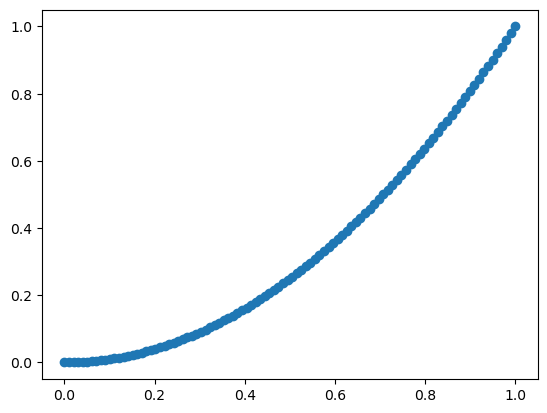

In [102]:
from matplotlib import pyplot as plt
import math

X = np.linspace(0, 1, num=100)
Y = [x**2 for x in X]

plt.scatter(X, Y)
plt.show()

X = X.reshape(100, 1)
Y = np.array(Y).reshape(100, 1)

In [111]:
def train(training_iters):

    model = Model([Linear(input_dim=1, output_dim=32),
                Sigmoid(),
                Linear(input_dim=32, output_dim=16),
                Sigmoid(),
                Linear(input_dim=16, output_dim=1),
                Sigmoid()])

    losses = []

    for i in range(training_iters):
        model.forward(X)
        losses.append(model.backward(Y))

    plt.plot(range(training_iters), losses)
    plt.title('Loss')
    plt.show()
    model_preds = model.forward(X)
    plt.plot(X, model_preds)
    plt.plot(X, Y)
    plt.title('Model Predictions vs Ground Truth')
    plt.show()

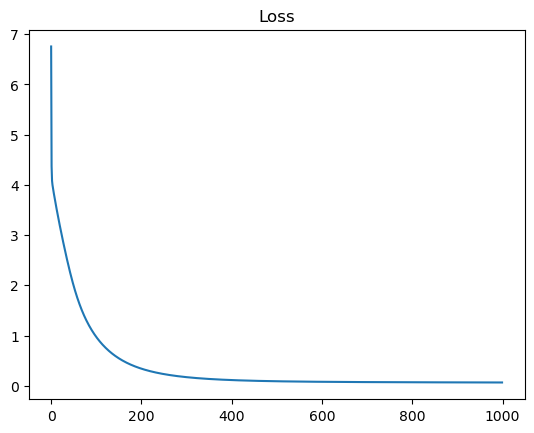

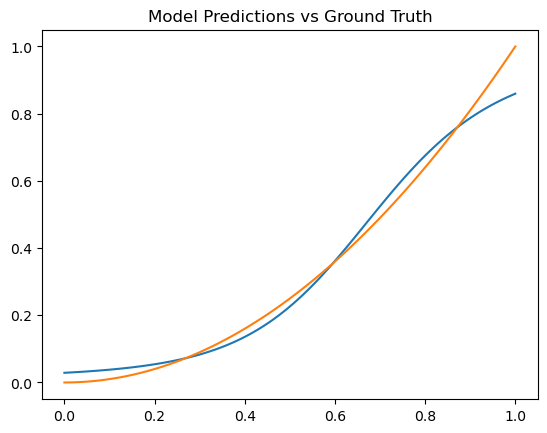

In [113]:
train(1000)

Our implementation works! The loss decreases over time. The model hasn't fit super well yet, though. Let's see if we can get this network to overfit.

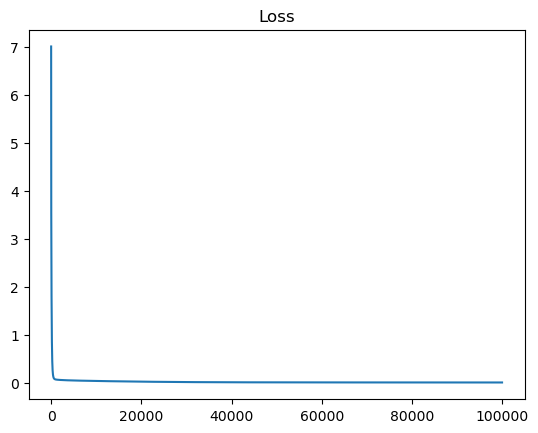

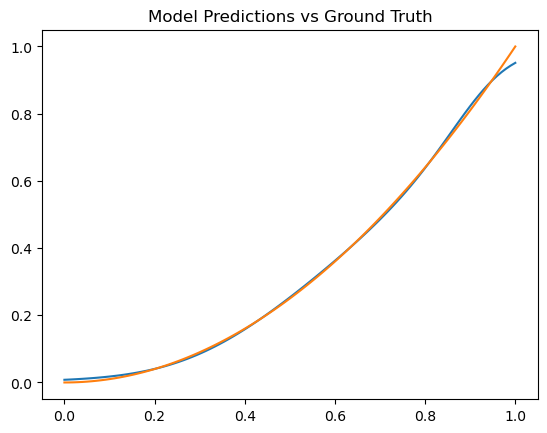

In [114]:
train(100000)

Close enough.

Thanks for following along!